In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import PIL.Image
import pandas as pd
import time
from datetime import timedelta
import math
import dataset_novalid
import random
import os
import cache
import vgg16
from vgg16 import transfer_values_cache
from vgg16 import transfer_values_calc
vgg16.maybe_download()
model=vgg16.VGG16()
import glob
import cv2
from PIL import Image,ImageFilter

Data has apparently already been downloaded and unpacked.


In [2]:

def reduce_colors(img, n):
    Z = img.reshape((-1,3))

    Z = np.float32(Z)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K = n
    ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

    center = np.uint8(center)
    res = center[label.flatten()]
    res2 = res.reshape((img.shape))

    return res2 

image_ctr=0

def image_preprocess(x_1,y_1,x_2,y_2,sample_path,save_cropped_path,save_test,sample_image,min_area):
    global image_ctr
    #for filename in glob.glob(os.path.join(sample_path, '*.png')):
    filename=os.path.join(sample_path,sample_image)
    img=cv2.imread(filename)
    crop_img = img[y_1:y_2, x_1:x_2]
    im_gray = cv2.cvtColor(crop_img, cv2.COLOR_BGR2GRAY)
    im_gray = cv2.GaussianBlur(im_gray, (5, 5), 0)
    #im_gray=cv2.equalizeHist(im_gray)
    im_gray = cv2.cvtColor(reduce_colors(cv2.cvtColor(im_gray, cv2.COLOR_GRAY2BGR), 8), cv2.COLOR_BGR2GRAY)
    ret, im_th = cv2.threshold(im_gray, 230, 255, cv2.THRESH_BINARY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (4, 4))
    im_th=cv2.erode(im_th, kernel, iterations = 1)
    img_bitwise=cv2.bitwise_not(im_th)
    ctrs = cv2.findContours(img_bitwise,cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)[1]

    char_mask = np.zeros_like(im_th)
    bounding_boxes = []

    for contour in ctrs:
            x,y,w,h = cv2.boundingRect(contour)
            area = w * h
            center = (x + w/2, y + h/2)
            if (area > min_area) and (area < 10000):
                 x,y,w,h = x-2, y-2, w+2, h+2
                 bounding_boxes.append((center, (x,y,w,h)))
                 cv2.rectangle(char_mask,(x,y),(x+w,y+h),255,-1)
                    
    clean = cv2.bitwise_not(cv2.bitwise_and(char_mask, char_mask, mask = img_bitwise))
    bounding_boxes = sorted(bounding_boxes, key=lambda item: item[0][0])
    characters = []
    for center, bbox in bounding_boxes:
        x,y,w,h = bbox
        char_image = clean[y:y+h,x:x+w]
        characters.append((bbox, char_image))

    output_img = cv2.cvtColor(clean, cv2.COLOR_GRAY2BGR)
    for bbox, char_img in characters:
        to_crop=output_img[bbox[1]:(bbox[1] + bbox[3]),bbox[0]:(bbox[0] + bbox[2])]
        save_str='cropped_'+str(image_ctr)+'.png'
        save_dir=os.path.join(save_cropped_path,save_str)
        cv2.imwrite(save_dir,to_crop)
        
        newImage = Image.new('L', (128, 128), (255)) #creates white canvas of 128x128 pixels
        to_open_str='cropped_'+str(image_ctr)+'.png'
        open_dir=os.path.join(save_cropped_path,to_open_str)
        im = Image.open(open_dir).convert('L')
        width = float(im.size[0])
        height = float(im.size[1])
        
        if width > height: #check which dimension is bigger
            nheight = int(round((50.0/width*height),0)) #resize height according to ratio width
            if (nheight == 0): 
                nheight = 1  
                # resize and sharpen
            img = im.resize((50,nheight), Image.ANTIALIAS).filter(ImageFilter.SHARPEN)
            wtop = int(round(((128 - nheight)/2),0)) #caculate horizontal pozition
            newImage.paste(img, (40, wtop)) #paste resized image on white canvas
        else:
            #Height is bigger. 
            nwidth = int(round((50.0/height*width),0)) #resize width according to ratio height
            if (nwidth == 0): 
                nwidth = 1
            img = im.resize((nwidth,50), Image.ANTIALIAS).filter(ImageFilter.SHARPEN)
            wleft = int(round(((128 - nwidth)/2),0)) #caculate vertical pozition
            newImage.paste(img, (wleft, 40)) #paste resized image on white canvas
        
        to_save_str='test_'+str(image_ctr)+'.png'   
        save_dir=os.path.join(save_test,to_save_str)
        newImage.save(save_dir)
        image_ctr=image_ctr+1

In [3]:
sample_path='samples_marrow/'
save_cropped_path='cropped_images/'
save_test='images_for_test/'
sample_image='Double sided20001.png'

In [4]:
#image_preprocess(x_1=50,y_1=230,x_2=1500,y_2=315,sample_path=sample_path,save_cropped_path=save_cropped_path,save_test=save_test,sample_image=sample_image)

In [5]:
classes=['0','1','2','3','4','5','6','7','8','9','A','A_LOW','B','B_LOW','C','C_LOW','D','D_LOW','E','E_LOW','F','F_LOW','G',
         'G_LOW','H','H_LOW','I','I_LOW','J','J_LOW','K','K_LOW','L','L_LOW','M','M_LOW','N','N_LOW','O','O_LOW','P','P_LOW','Q',
         'Q_LOW','R','R_LOW','S','S_LOW','T','T_LOW','U','U_LOW','V','V_LOW','W','W_LOW','X','X_LOW','Y','Y_LOW','Z','Z_LOW']

class_numbers=list(range(62))
num_classes=len(classes)
num_channels=3
img_size = 128
#custom paths
test_path = 'test_docs/'
test_data = dataset_novalid.read_test_set(test_path, img_size,classes)

Reading test images
Loading 0 files (Index: 0)
Loading 1 files (Index: 1)
Loading 2 files (Index: 2)
Loading 3 files (Index: 3)
Loading 4 files (Index: 4)
Loading 5 files (Index: 5)
Loading 6 files (Index: 6)
Loading 7 files (Index: 7)
Loading 8 files (Index: 8)
Loading 9 files (Index: 9)
Loading A files (Index: 10)
Loading A_LOW files (Index: 11)
Loading B files (Index: 12)
Loading B_LOW files (Index: 13)
Loading C files (Index: 14)
Loading C_LOW files (Index: 15)
Loading D files (Index: 16)
Loading D_LOW files (Index: 17)
Loading E files (Index: 18)
Loading E_LOW files (Index: 19)
Loading F files (Index: 20)
Loading F_LOW files (Index: 21)
Loading G files (Index: 22)
Loading G_LOW files (Index: 23)
Loading H files (Index: 24)
Loading H_LOW files (Index: 25)
Loading I files (Index: 26)
Loading I_LOW files (Index: 27)
Loading J files (Index: 28)
Loading J_LOW files (Index: 29)
Loading K files (Index: 30)
Loading K_LOW files (Index: 31)
Loading L files (Index: 32)
Loading L_LOW files (I

In [6]:
images_test,labels_test,cls_test,ids_test=test_data.test.images,test_data.test.labels,test_data.test.cls,test_data.test.ids
print("Size of:")
print("- Test-set:\t\t{}".format(len(test_data.test.images)))

Size of:
- Test-set:		5072


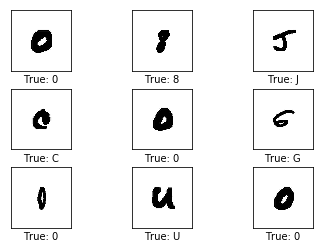

In [10]:
def plot_images(images, cls_true, cls_pred=None):
    
    if len(images) == 0:
        print("no images to show")
        return 
    else:
        random_indices = random.sample(range(len(images)), min(len(images), 9))
        
        
    images, cls_true  = zip(*[(images[i], cls_true[i]) for i in random_indices])
    
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):

        ax.imshow(images[i].reshape(img_size, img_size, num_channels))


        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()
    

plot_images(images=images_test,cls_true=cls_test,cls_pred=None)

In [11]:
cache_path= 'C:/Users/Konstantin/Machine Learning/NIST Handwritten project/cache_NIST'
file_path_cache_train = os.path.join(cache_path, 'vgg16_train_full_pool5_2.pkl')
file_path_cache_test = os.path.join('D:/Konstantin/cache_docs/full_dcs_1.pkl')
images_train=os.path.join(cache_path, 'images_train_2.pkl')
labels_train=os.path.join(cache_path, 'labels_train_2.pkl')
cls_train=os.path.join(cache_path, 'cls_train_2.pkl')
ids_train=os.path.join(cache_path, 'ids_train_2.pkl')

In [12]:
print("Processing VGG 16 transfer-values for training-images ...")

transfer_values_train = transfer_values_cache(cache_path=file_path_cache_train,
                                              images=images_train,
                                              model=model)

Processing VGG 16 transfer-values for training-images ...
- Data loaded from cache-file: C:/Users/Konstantin/Machine Learning/NIST Handwritten project/cache_NIST\vgg16_train_full_pool5_2.pkl


In [15]:
print("Processing VGG 16 transfer-values for test-images ...")

transfer_values_test = transfer_values_cache(cache_path=file_path_cache_test,
                                             images=images_test,
                                             model=model)

Processing VGG 16 transfer-values for test-images ...
- Processing image:   5072 / 5072
- Data saved to cache-file: D:/Konstantin/cache_docs/full_dcs_1.pkl


In [14]:
transfer_values_train_r=transfer_values_train.reshape(100000,8192)
transfer_values_test_r=transfer_values_test.reshape(len(test_data.test.labels),8192)
transfer_len=8192
cls_test = np.array([label.argmax() for label in labels_test])
fc_size=2048
keep_prob=0.5
tf_reg=2e-3
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))
def new_fc_layer(input,          
                 num_inputs,     
                 num_outputs,
                 keep_prob,
                 l2_loss,
                 use_relu=True,
                use_dropout=True,
                ): 

    
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)
    result_loss=l2_loss*tf.nn.l2_loss(weights)
   
    layer = tf.matmul(input, weights) + biases

    
    if use_relu:
        layer = tf.nn.relu(layer)
    if use_dropout:
        layer = tf.nn.dropout(layer,keep_prob)
    return layer,result_loss
def random_batch():
    
    num_images = len(transfer_values_train_r)

    
    idx = np.random.choice(num_images,
                           size=train_batch_size,
                           replace=False)

    
    x_batch = transfer_values_train_r[idx]
    y_batch = labels_train[idx]

    return x_batch, y_batch
x = tf.placeholder(tf.float32, shape=[None, transfer_len], name='x')
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)

layer_fc1,fc1_loss = new_fc_layer(input=x,
                         num_inputs=transfer_len,
                         num_outputs=fc_size,
                         l2_loss=tf_reg,
                         keep_prob=keep_prob,
                         use_relu=True,
                        use_dropout=False)
layer_fc2,fc2_loss = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=fc_size,
                         l2_loss=tf_reg,
                         keep_prob=keep_prob,
                         use_relu=True,
                        use_dropout=False)
layer_fc3,fc3_loss = new_fc_layer(input=layer_fc2,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         l2_loss=tf_reg,
                         keep_prob=keep_prob,
                         use_relu=False,use_dropout=False)
y_pred = tf.nn.softmax(layer_fc3)
y_pred_cls = tf.argmax(y_pred, dimension=1)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc3,
                                                        labels=y_true)
cost = tf.reduce_mean(cross_entropy)+fc1_loss+fc2_loss+fc3_loss
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)
y_pred_cls = tf.argmax(y_pred, dimension=1)
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

feed_dict_test = {x: transfer_values_test_r,
                  y_true: labels_test}
feed_dict_train = {x: transfer_values_train_r,
                  y_true: labels_train}
def print_accuracy_test():
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    print("Accuracy on test-set: {0:.1%}".format(acc))
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cls_pred):
    global class_numbers
    cm = confusion_matrix(y_true=cls_test,  
                          y_pred=cls_pred,
                         labels=class_numbers)  

    
    for i in range(num_classes):
       
        class_name = "({}) {}".format(i, classes[i])
        print(cm[i, :], class_name)

    
    class_numbers = [" ({0})".format(i) for i in range(num_classes)]
    print("".join(class_numbers))
def plot_example_errors(cls_pred, correct):
    
    incorrect = (correct == False)
    
   
    images = images_test[incorrect]
    
    
    cls_pred = cls_pred[incorrect]

    
    cls_true = cls_test[incorrect]

    n = min(9, len(images))
    
    # Plot the first n images.
    plot_images(images=images[0:n],
                cls_true=cls_true[0:n],
                cls_pred=cls_pred[0:n])

batch_size = 256

def predict_cls(transfer_values, labels, cls_true):
    
    num_images = len(transfer_values)

    
    cls_pred = np.zeros(shape=num_images, dtype=np.int)

    
    i = 0

    while i < num_images:
        
        j = min(i + batch_size, num_images)   
        feed_dict = {x: transfer_values[i:j],
                     y_true: labels[i:j]}       
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)      
        i = j
        
    
    correct = (cls_true == cls_pred)
    print (correct)
    return correct, cls_pred
def predict_cls_test():
    return predict_cls(transfer_values = transfer_values_test_r,
                       labels = labels_test,
                       cls_true = cls_test)
def classification_accuracy(correct):
    return correct.mean(), correct.sum()
def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    correct, cls_pred = predict_cls_test()
    acc, num_correct = classification_accuracy(correct)
    num_images = len(correct)

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, num_correct, num_images))
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)


INFO:tensorflow:Restoring parameters from checkpoints/best_test-2
Model restored.
Accuracy on test-set: 41.9%
[ True False  True ..., False False False]
Accuracy on Test-Set: 41.9% (2127 / 5072)
Example errors:


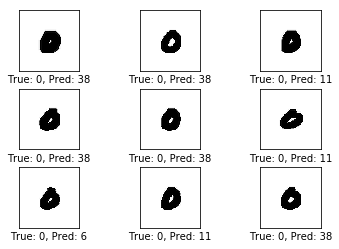

Confusion Matrix:
[458   0   0   1   0   0   3   0   0   0   0  52  22   7   1   0  25   0
   0   0   0   0   0   0   0   0   0   0   3   0   0   0   0   0   0   0
   0   0 699  57   1   0   0   0   0   0   0   0   0   0  10   0   0   0
   0   1   0   0   0   0   0   2] (0) 0
[  0   2   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0 124   0   0   0   0   0   1 102   0   0
   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0
   0   0   0   0   0   0   1   3] (1) 1
[ 0  0 59  0  0  0  0  0  0  0  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  1  0  0  0  1  0  0  0  0  2  0  0  0  0  0  0  0  1  2  0  0  0
  0  0  0  0  0  0  0  0  0  0 10 20] (2) 2
[ 0  0  1 37  0  0  0  3  0  0  0  0  1  0  0  0  2  0  1  0  0  0  0  1  0
  1  0  0  0  2  0  0  0  0  0  0  0  1  0  0  0  0  0  2  0  0  8  3  0  0
  0  0  0  0  0  0  0  0  0  0  1  0] (3) 3
[ 0  0  0  0 15  0  0  0  0  0  0  1  1  0  0  0  0  0  0  0  0  0  0  0

In [17]:
save_path='checkpoints/best_test-2'
with tf.Session() as session:
    saver=tf.train.Saver()
    saver.restore(session, save_path)
    print("Model restored.")
    print_accuracy_test()
    print_test_accuracy(show_example_errors=True,
                        show_confusion_matrix=True)
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)
    index=0
    for cls in cls_pred:
        print('Predicted class for index {0}:{1}(correct is {2})'.format(index,classes[cls],classes[cls_test[index]]))
        index=index+1

In [18]:

print("Documents results( accuracy w/o 0-O,upper to lowercase errors):")
pot_acc=((2127+1292)/5072)*100
print(pot_acc)

Documents results:
67.40930599369085


In [19]:

print("Documents results( accuracy w/o 1-I-L errors):")
pot_acc=((2127+1535)/5072)*100
print(pot_acc)

Documents results:
72.20031545741324


# Test area prediction

In [4]:
sample_path='samples_marrow/'
save_cropped_path='crop_test/'
save_test='im_test/'
sample_image='Double sided20001.png'

In [5]:
image_preprocess(x_1=104,y_1=228,x_2=1425,y_2=310,sample_path=sample_path,save_cropped_path=save_cropped_path,save_test=save_test,sample_image=sample_image,min_area=450)

In [6]:
classes=['0','1','2','3','4','5','6','7','8','9','A','A_LOW','B','B_LOW','C','C_LOW','D','D_LOW','E','E_LOW','F','F_LOW','G',
         'G_LOW','H','H_LOW','I','I_LOW','J','J_LOW','K','K_LOW','L','L_LOW','M','M_LOW','N','N_LOW','O','O_LOW','P','P_LOW','Q',
         'Q_LOW','R','R_LOW','S','S_LOW','T','T_LOW','U','U_LOW','V','V_LOW','W','W_LOW','X','X_LOW','Y','Y_LOW','Z','Z_LOW']

class_numbers=list(range(62))
num_classes=len(classes)
num_channels=3
img_size = 128
#custom paths
test_path = 'im_test/'
test_data = dataset_novalid.read_custom_test(test_path, img_size,classes)

Reading test images


In [7]:
images_test,labels_test,cls_test,ids_test=test_data.test.images,test_data.test.labels,test_data.test.cls,test_data.test.ids
print("Size of:")
print("- Test-set:\t\t{}".format(len(test_data.test.images)))


Size of:
- Test-set:		19


In [13]:
file_path_cache_test = os.path.join('D:/Konstantin/cache_docs/test_dcs_1.pkl')
print("Processing VGG 16 transfer-values for test-images ...")

transfer_values_test = transfer_values_cache(cache_path=file_path_cache_test,
                                             images=images_test,
                                             model=model)

Processing VGG 16 transfer-values for test-images ...
- Processing image:     19 / 19
- Data saved to cache-file: D:/Konstantin/cache_docs/test_dcs_1.pkl


In [15]:
save_path='checkpoints/best_test-2'
with tf.Session() as session:
    saver=tf.train.Saver()
    saver.restore(session, save_path)
    print("Model restored.")
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)
    index=0
    print('Predicted output:')
    for cls in cls_pred:
        print(classes[cls])
        index=index+1
    

INFO:tensorflow:Restoring parameters from checkpoints/best_test-2
Model restored.
Predicted output:
I
2
Z
4
S
C
D
G_LOW
O_LOW
I
O
F
B
C
D
O
F
G
H


True images in order:


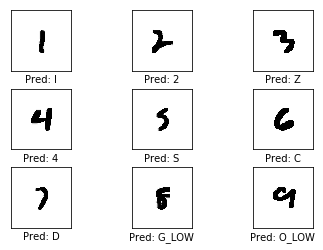

In [49]:
def plot_images_custom(images,cls_pred,r1,r2):
    
    if len(images) == 0:
        print("no images to show")
        return 
    else:
        indices = list(range(r1,r2))
        
        
    images  = [(images[i]) for i in indices]
    
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    ctr=r1
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(img_size, img_size, num_channels))
        xlabel = "Pred: {0}".format(classes[cls_pred[ctr]])
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])
        ctr=ctr+1
    plt.show()
print('True images in order:')
plot_images_custom(images=images_test,cls_pred=cls_pred,r1=0,r2=9)

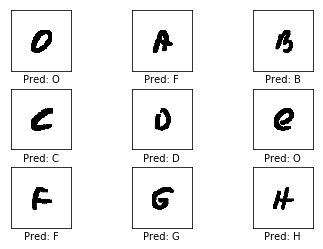

In [50]:
plot_images_custom(images=images_test,cls_pred=cls_pred,r1=10,r2=19)